<a href="https://colab.research.google.com/github/Zelkova46/MOP_cpmk4/blob/main/paleto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

def f1(x):
    if len(x.shape) == 1:  # only one x observation
        return np.mean(np.power(x, 1))
    else:
        return np.mean(np.power(x, 1), axis=1)


def f2(x):
    if len(x.shape) == 1:  # only one x observation
        return np.mean(np.power(x, 2))
    else:
        return np.mean(np.power(x, 2), axis=1)

def satisfies_constraint(x):
    return np.sum(np.power(x, 2)) <= 1000

def pareto_dominance(x, tourn_x):
    f_1 = f1(x)
    f_2 = f2(x)
    tourn_f1 = f1(tourn_x)
    tourn_f2 = f2(tourn_x)
    score = 0
    if len(tourn_x.shape) == 1:  # only one x observation
        if f_1 <= tourn_f1 and f_2 <= tourn_f2:  # atleast equal in all objectives
            score += 2
            if f_1 < tourn_f1 or f_2 < tourn_f2:  # strong dominance
                score += 2
        elif f_1 < tourn_f1 or f_2 < tourn_f2:  # weak domination
            score += 1
    else:
        for i in range(0, len(tourn_x)):
            if f_1 <= tourn_f1[i] and f_2 <= tourn_f2[i]:  # atleast equal in all objectives
                score += 2
                if f_1 < tourn_f1[i] or f_2 < tourn_f2[i]:  # strong dominance
                    score += 2
            elif f_1 < tourn_f1[i] or f_2 < tourn_f2[i]:  # weak domination
                score += 1

    return score

def crossover_method_1(par):
    child = np.copy(par[0])
    for j in range(0, np.shape(par[0])[0]):
        child[j] = np.mean(par[:,j])
    return child

def crossover_method_2(par):
    child = np.copy(par[0])
    n = np.shape(par[0])[0]

    random_nums = np.random.randint(low=0, high=len(par),size=n)
    for j in range(0,n):
        child[j] = par[random_nums[j]][j]

    return child

def mutate(par_val, par_sigma):
    n_x = len(par_val)
    tau = 1 / (np.sqrt(2 * np.sqrt(n_x)))
    tau_prime = 1 / (np.sqrt(2 * n_x))
    r = np.random.normal(0,1,len(par_sigma))
    ch_sigma = par_sigma*np.exp(tau*r+tau_prime*r)
    r = np.random.normal(0,1,len(par_sigma))
    ch_val = np.copy(par_val)+ch_sigma*r
    return ch_val, ch_sigma

def reproduction(par, sigma, cross_method):
    if cross_method==1:
        child_val = crossover_method_1(par)
        child_sigma = crossover_method_1(sigma)
    else:
        child_val = crossover_method_2(par)
        child_sigma = crossover_method_2(sigma)

    mut_child_val, mut_child_sigma = mutate(child_val, child_sigma)


    f = pareto_dominance(child_val, mut_child_val)
    if f == 4:  # strong domination
        return child_val, child_sigma
    elif f == 2:  # weak domination
        r = np.random.uniform(0, 1, 1)
        if r < 0.5:  # randomly select winner
            return child_val, child_sigma
        else:
            return mut_child_val, mut_child_sigma
    else:  # no domination
        return mut_child_val, mut_child_sigma

    ch_val = []
    ch_sigma = []
    for i in range(0, n):
        c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)

        # Check if the child solution satisfies the constraint
        if satisfies_constraint(c_v):
            ch_val.append(c_v)
            ch_sigma.append(c_s)

    return np.asarray(ch_val), np.asarray(ch_sigma)

def evolutionary_strategy_pareto_algorithm(size, var_count, max_distance=2, max_iter=50,
                                           cross_method=1, par_count=2, archive_iter=30):

    lower_bound = [-10] * var_count
    upper_bound = [10] * var_count
    bounds = [upper_bound, lower_bound]
    archive = []
    # outer loop
    for q in range(0, archive_iter):
        # create initial generation with strategy parameters
        init_gen = np.empty(shape=(size, var_count))
        init_sigma = np.empty(shape=(size, var_count))
        for i in range(0, var_count):
            init_sigma[:, i] = np.random.uniform(0.5, 5, size)
            init_gen[:, i] = np.random.uniform(-10, 10, size)
        n, c = init_gen.shape
        tourn_size = int(0.05 * n)

        print("Archive {}".format(q + 1))
        gen = np.copy(init_gen)
        sigma = np.copy(init_sigma)
        # inner loop
        for k in range(0, max_iter):

            # random selection based off number of parents
            selected = []
            for i in range(0, par_count):
                selected.append(np.random.choice(range(0, n), n, replace=False))
            selected = np.asarray(selected).T
            ch_val = []
            ch_sigma = []
            # reproduce from parents
            for i in range(0, n):
                c_v, c_s = reproduction(gen[selected[i]], sigma[selected[i]], cross_method)
                ch_val.append(c_v)
                ch_sigma.append(c_s)

            ch_val = np.asarray(ch_val)
            ch_sigma = np.asarray(ch_sigma)
            # Check bounds and constraint of offspring
            for i in range(0, n):
                for j in range(0, c):
                    if ch_val[i][j] > bounds[0][j]:
                        ch_val[i][j] = bounds[0][j]
                        ch_sigma[i][j] *= 0.90
                    elif ch_val[i][j] < bounds[1][j]:
                        ch_val[i][j] = bounds[1][j]
                        ch_sigma[i][j] *= 0.90

                # Check if the child solution satisfies the constraint
                if not satisfies_constraint(ch_val[i]):
                    # Regenerate the variable that violates the constraint
                    for j in range(0, c):
                        ch_val[i][j] = np.random.uniform(bounds[1][j], bounds[0][j])
                        ch_sigma[i][j] = np.random.uniform(0.5, 5)


            # combine offspring with parents
            parents_offspring_val = np.vstack((gen, ch_val))
            parents_offspring_sigma = np.vstack((sigma, ch_sigma))
            ind = list(range(0, 2*n))
            rel_fit = []
            # compute relative fitness
            for i in range(0, 2*n):
                tourn = np.random.choice(ind[0:i]+ind[(i+1):], tourn_size)
                rel_fit.append(pareto_dominance(parents_offspring_val[i], parents_offspring_val[tourn]))

            if q != 0:  # not first iteration of outer loop
                # loop over each member in archive
                for arch in archive:
                    for i in range(0, 2*n):
                        # calculate euclidean distance
                        dist = np.linalg.norm(arch-parents_offspring_val[i])
                        # if their distance is small -> they're too close,
                        # larger the max distance the more spread out solutions become
                        if dist <= max_distance:
                            # penalize fitness down to 25%
                            rel_fit[i] *= 0.25

            # sort individuals based on relative fitness
            rel_fit = np.asarray(rel_fit)
            sorted_ind = np.asarray(ind)[np.argsort(-rel_fit)]

            # use elitism to take the best half from pooled
            # parents and offspring
            gen = parents_offspring_val[sorted_ind[0:n]]
            sigma = parents_offspring_sigma[sorted_ind[0:n]]

            # calculate best for printing out information
            fit_f1 = f1(gen)
            fit_f2 = f2(gen)
            fit_best_f1 = np.min(fit_f1)
            fit_mean_f1 = np.mean(fit_f1)
            fit_best_f2 = np.min(fit_f2)
            fit_mean_f2 = np.mean(fit_f2)
            msg = "GENERATION {}:\n" \
                  " F1: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n"\
                  " F2: \n" \
                  "  Best Fit: {}, Mean Fit: {}\n".format(k, fit_best_f1, fit_mean_f1, fit_best_f2, fit_mean_f2)
            print(msg)

        # update archive
        if q != 0:
            # loop over every individual in surviving generation
            for j in range(0, len(gen)):
                # indices of members in archive that are dominated by
                # the current individual
                ind_del = []
                f1_arch = f1(np.asarray(archive))
                f2_arch = f2(np.asarray(archive))
                dominated = False
                for i in range(0, len(archive)):
                    # individual strongly dominates member of archive
                    if f1_arch[i] > fit_f1[j] and f2_arch[i] > fit_f2[j]:
                        ind_del.append(i)  # add member index for deletion
                    # individual is strongly dominated by member
                    elif f1_arch[i] < fit_f1[j] and f2_arch[i] < fit_f2[j]:
                        dominated = True
                if len(ind_del) != 0:
                    # delete members that are strongly dominated
                    for index in sorted(ind_del, reverse=True):
                        del archive[index]
                if not dominated:  # weakly dominates members of archive
                    archive.append(gen[j])

        else:  # if first iteration of outer loop, just add best solution from gen
            archive.append(gen[0])


    return np.asarray(archive)

arch = evolutionary_strategy_pareto_algorithm(size=100, var_count=10, max_distance=0.75,
                                              max_iter=40, cross_method=1, par_count=3,
                                              archive_iter=100)

Streaming output truncated to the last 5000 lines.
GENERATION 10:
 F1: 
  Best Fit: -6.411623235850016, Mean Fit: -4.459828564117745
 F2: 
  Best Fit: 11.755994880274992, Mean Fit: 25.40338495786737

GENERATION 11:
 F1: 
  Best Fit: -7.130198773965809, Mean Fit: -4.7838640990542265
 F2: 
  Best Fit: 12.866941381826837, Mean Fit: 29.17606795470968

GENERATION 12:
 F1: 
  Best Fit: -7.403899808236714, Mean Fit: -4.992042327402188
 F2: 
  Best Fit: 14.479472495520938, Mean Fit: 30.988609774270493

GENERATION 13:
 F1: 
  Best Fit: -6.739812838885359, Mean Fit: -5.029904758351312
 F2: 
  Best Fit: 15.884705772799549, Mean Fit: 30.242991029512105

GENERATION 14:
 F1: 
  Best Fit: -7.668594710983444, Mean Fit: -5.316388987418386
 F2: 
  Best Fit: 11.460122199355421, Mean Fit: 33.66408687355967

GENERATION 15:
 F1: 
  Best Fit: -7.5698240595737145, Mean Fit: -5.437838291055596
 F2: 
  Best Fit: 14.187596691509778, Mean Fit: 35.038510736530505

GENERATION 16:
 F1: 
  Best Fit: -7.49508786786966

In [2]:

import matplotlib.pyplot as plt

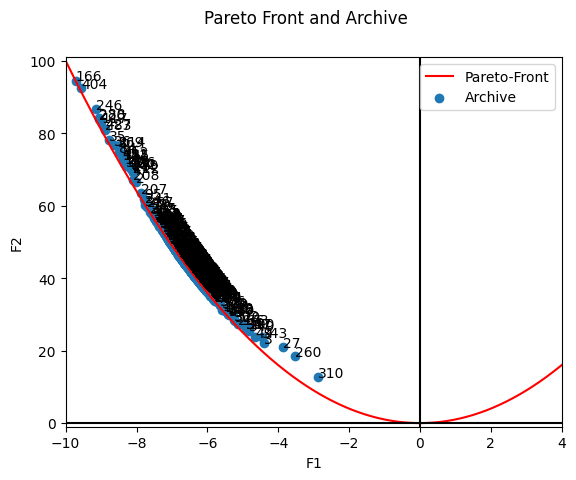

In [28]:

# Visualize Pareto front and archive
x = np.arange(-1000, 1000, 0.01).reshape(-1, 1)

plt.plot(f1(x), f2(x), label="Pareto-Front", c="red")

f1_arch = f1(arch)
f2_arch = f2(arch)

plt.scatter(f1_arch, f2_arch, label="Archive")

plt.xlabel("F1")
plt.ylabel("F2")

plt.legend()

plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.suptitle("Pareto Front and Archive")

plt.xlim([-10, 4])
plt.ylim([-1, 101])

# Highlight the Pareto front points in the archive
for i, txt in enumerate(f1_arch):
    plt.annotate(i, (f1_arch[i], f2_arch[i]))

plt.show()

In [23]:
len(f1_arch)

444

In [6]:
print(f1_arch)

[-6.45400421 -6.46468349 -8.02771495 -4.39945299 -6.47104503 -6.66777448
 -5.27239714 -6.0454121  -7.14047838 -6.15209564 -6.90357341 -6.58123938
 -6.6409358  -7.45049122 -6.92738381 -7.53985025 -6.89014498 -8.10279422
 -6.79398711 -8.34374677 -7.02793578 -6.74574739 -5.93926506 -6.72343351
 -6.69946321 -8.10658005 -6.57978324 -3.85698742 -5.84492143 -6.10306993
 -6.47958623 -6.056894   -7.32750594 -6.10121523 -6.11750187 -8.76815591
 -8.64014145 -7.23105111 -7.34729671 -5.98306428 -6.99767763 -6.88612723
 -6.77411922 -7.08558613 -6.8952138  -6.917868   -6.68967623 -6.60677018
 -6.9811284  -4.65019706 -6.43489265 -5.39781759 -6.62681642 -6.00093441
 -6.29672419 -6.03911614 -6.40722006 -6.33175961 -6.19520599 -6.20013906
 -5.97698606 -6.16288374 -5.82760988 -6.17279848 -6.22630607 -7.23215917
 -6.54878746 -8.25404381 -6.79318563 -6.20456469 -6.33265903 -5.70912312
 -6.40215631 -8.17712819 -6.32317411 -6.77793813 -6.94535341 -6.82034676
 -6.91211516 -6.84120926 -6.86046142 -6.76975266 -6

In [24]:
len(f2_arch)

444

In [7]:
print(f2_arch)

[41.80876581 41.90783541 66.42274775 21.96994015 41.98344275 44.51939858
 29.42875021 36.83572423 51.16199846 38.03013684 47.84896053 43.45753245
 44.19644841 55.75596116 48.18189355 57.32777225 47.58859599 69.2741033
 46.37680545 71.79648645 49.58532406 45.69627971 35.74057745 45.27494065
 45.04062083 69.77263926 43.38746709 21.03024228 34.51788351 37.47744993
 42.11513657 36.91735687 54.05507712 37.42054522 37.50098311 77.99551308
 76.80217053 52.52250143 54.38342553 36.05273591 49.2329468  47.52664057
 46.00540863 50.34712607 47.6513606  47.91199622 44.89014776 43.80521089
 48.89704325 23.83241419 41.55210493 29.827351   44.06571592 36.3566389
 39.75068931 36.56352852 41.22327068 40.20810039 38.54871452 38.62397335
 35.94119954 38.22389273 34.26386448 38.3725675  38.97817067 52.89663995
 42.97115478 71.0094944  46.35919793 38.6860703  40.24282355 33.29252145
 41.11299475 70.5904335  40.18995351 46.06279073 48.39949377 46.71334399
 47.88497108 46.91987909 47.17873418 45.9384177  49.1

In [8]:
print(arch)

[[ -6.49130758  -6.84797811  -6.30908992 ...  -6.08666674  -7.29150363
   -6.52198726]
 [ -6.55552782  -6.73165146  -6.50695156 ...  -6.3028234   -7.19591308
   -6.61327261]
 [ -8.47866606  -7.47665867  -6.79620591 ...  -6.44244049  -6.95259369
  -10.        ]
 ...
 [ -6.52108448  -7.20769374  -6.62148228 ...  -6.61504797  -6.2720595
   -7.16148097]
 [ -6.49821452  -5.91522712  -6.78053811 ...  -6.69395896  -6.64251676
   -7.13919454]
 [ -7.05456786  -6.40092361  -7.01572118 ...  -6.82398648  -6.68830007
   -7.23253502]]


In [25]:
print(x)

[[-1000.  ]
 [ -999.99]
 [ -999.98]
 ...
 [  999.97]
 [  999.98]
 [  999.99]]


In [26]:
print(txt)

-6.816562298164738
